# Générateur de Noms de Domaine avec LLM
## Expérimentations et Évaluations Systématiques

Ce notebook présente le développement itératif d'un système de génération de noms de domaine utilisant des modèles de langage, avec un focus sur l'évaluation automatisée et la découverte de cas limites.

## 1. Configuration et Imports

In [1]:
import sys
import time
sys.path.append("..")
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from datetime import datetime
from typing import Dict, List
import matplotlib.pyplot as plt

from langchain.prompts import PromptTemplate

# Import des modules du projet
from src.creation_dataset import CreationDataset
from src.generateur_nom_domaine import GenerateurNomsDomaine
from src.utils import charger_json, sauvegarder_json, generer_timestamp, logger, nettoyer_nom_domaine
from src.garde_fous import GardeFousSecurite, TesteurSecurite
from src.evaluateur_llm import EvaluateurLLM


print(f"Date de l'expérience: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Date de l'expérience: 2025-08-06 00:28:01


## 2. Création du Dataset Synthétique

Nous commençons par créer un dataset synthétique diversifié pour l'évaluation.

In [2]:
# Initialiser le créateur de dataset
creation_dataset = CreationDataset()

# Créer le dataset complet
print("Création du dataset synthétique...")
chemin_dataset = creation_dataset.sauvegarder_dataset("dataset_experimental.json")

# Charger et analyser le dataset créé
dataset_complet = charger_json(chemin_dataset)

print(f"Dataset créé avec succès:")
print(f"   - Exemples d'entraînement: {len(dataset_complet['entrainement'])}")
print(f"   - Cas limites: {len(dataset_complet['cas_limites'])}")

# Visualisation de la distribution des types de business
descriptions = [ex['description_business'] for ex in dataset_complet['entrainement']]
print(f"\nExemples de descriptions générées:")
for i, desc in enumerate(descriptions[:5]):
    print(f"   {i+1}. {desc}")

INFO:src.utils:Génération d'un dataset de 1000 exemples...
INFO:src.utils:Généré 100/1000 exemples
INFO:src.utils:Généré 200/1000 exemples
INFO:src.utils:Généré 300/1000 exemples
INFO:src.utils:Généré 400/1000 exemples
INFO:src.utils:Généré 500/1000 exemples
INFO:src.utils:Généré 600/1000 exemples
INFO:src.utils:Généré 700/1000 exemples
INFO:src.utils:Généré 800/1000 exemples
INFO:src.utils:Généré 900/1000 exemples
INFO:src.utils:Généré 1000/1000 exemples
INFO:src.utils:Données sauvegardées dans ../data/dataset_experimental.json
INFO:src.utils:Dataset complet sauvegardé: ../data/dataset_experimental.json
INFO:src.utils:Données chargées depuis ../data/dataset_experimental.json


Création du dataset synthétique...
Dataset créé avec succès:
   - Exemples d'entraînement: 1000
   - Cas limites: 14

Exemples de descriptions générées:
   1. Service de médecine générale via cabinet premium
   2. distribution maison dans en ligne
   3. clinique kinésithérapie dans centre médical
   4. développement mobile dans Paris
   5. traiteur français dans quartier résidentiel


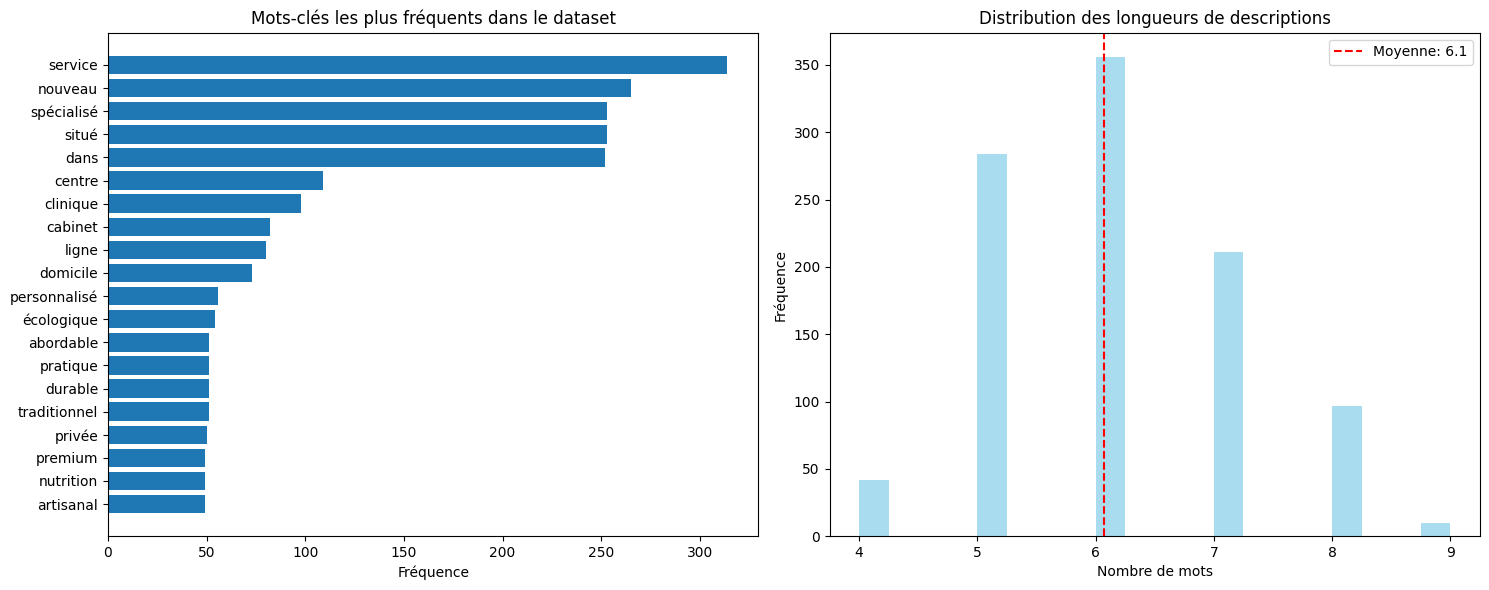

Statistiques du dataset:
   - Longueur moyenne des descriptions: 6.1 mots
   - Longueur médiane: 6.0 mots
   - Vocabulaire unique: 90 mots


In [3]:
# Analyser les mots-clés les plus fréquents
tous_mots = []
for desc in descriptions:
    mots = desc.lower().split()
    tous_mots.extend([mot for mot in mots if len(mot) > 3])

mots_frequents = collections.Counter(tous_mots).most_common(20)

# Créer une visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des mots les plus fréquents
mots, freq = zip(*mots_frequents)
ax1.barh(range(len(mots)), freq)
ax1.set_yticks(range(len(mots)))
ax1.set_yticklabels(mots)
ax1.set_xlabel('Fréquence')
ax1.set_title('Mots-clés les plus fréquents dans le dataset')
ax1.invert_yaxis()

# Distribution des longueurs de descriptions
longueurs = [len(desc.split()) for desc in descriptions]
ax2.hist(longueurs, bins=20, alpha=0.7, color='skyblue')
ax2.set_xlabel('Nombre de mots')
ax2.set_ylabel('Fréquence')
ax2.set_title('Distribution des longueurs de descriptions')
ax2.axvline(np.mean(longueurs), color='red', linestyle='--', label=f'Moyenne: {np.mean(longueurs):.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Statistiques du dataset:")
print(f"   - Longueur moyenne des descriptions: {np.mean(longueurs):.1f} mots")
print(f"   - Longueur médiane: {np.median(longueurs):.1f} mots")
print(f"   - Vocabulaire unique: {len(set(tous_mots))} mots")

## 3. Initialisation du Modèle Générateur

Configuration et test initial du générateur basé sur Llama3.1

In [4]:
# Initialiser le générateur de base
print("Initialisation du générateur de noms de domaine...")
try:
    generateur = GenerateurNomsDomaine(model="llama3.1", garde_fous=True, garde_fous_use_llm=False)
    info_modele = generateur.obtenir_info_modele()
    
    print("Générateur initialisé avec succès")
    print(f"   - Modèle: {info_modele['nom_modele']}")
    print(f"   - URL de base: {info_modele['base_url']}")
    print(f"   - Garde-fous activés: {info_modele['garde_fous_actifs']}")
    print(f"   - Styles disponibles: {', '.join(info_modele['styles_disponibles'])}")
    
except Exception as e:
    print(f"Erreur lors de l'initialisation: {e}")
    print("Vérifiez qu'Ollama est en cours d'exécution et que le modèle llama3.1 est téléchargé")
    print("   Commandes à exécuter:")
    print("   - ollama serve")
    print("   - ollama pull llama3.1")

INFO:src.utils:Modèle llama3.1 initialisé avec succès


Initialisation du générateur de noms de domaine...
Générateur initialisé avec succès
   - Modèle: llama3.1
   - URL de base: http://localhost:11434
   - Garde-fous activés: True
   - Styles disponibles: professionnel, creatif, moderne, classique, court


In [5]:
# Test initial avec des exemples variés
descriptions_test = [
    "restaurant italien familial avec terrasse au centre-ville",
    "startup de développement d'applications mobiles innovantes",
    "cabinet de conseil en marketing digital pour PME",
    "boutique de vêtements bio et éthiques en ligne",
    "école de formation en intelligence artificielle"
]

print("Tests initiaux du générateur ...\n")

resultats = []

for i, description in enumerate(descriptions_test, 1):
    print(f"Test {i}/{len(descriptions_test)}: {description}")

    try:
        resultat = generateur.generer_suggestions(
            description_business=description,
            nombre_suggestions=3,
            style="professionnel"
        )
        
        if resultat["status"] == "success":
            print("Suggestions générées:")
            for suggestion in resultat["suggestions"]:
                print(f"   - {suggestion['domaine']} (confiance: {suggestion['confidence']})")
            print(f"   Durée: {resultat['metadata']['duree_generation_sec']}s\n")
            
            resultats.append({
                "description": description,
                "resultats": resultat
            })
        else:
            print(f"Échec: {resultat.get('message', 'Erreur inconnue')}\n")
            
    except Exception as e:
        print(f"Erreur: {e}\n")

print(f"Tests baseline terminés: {len(resultats)}/{len(descriptions_test)} réussis")

INFO:src.utils:Génération de 3 | suggestions pour: restaurant italien familial avec terrasse au centr...


Tests initiaux du générateur ...

Test 1/5: restaurant italien familial avec terrasse au centre-ville


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: startup de développement d'applications mobiles in...


Suggestions générées:
   - bellavista.com (confiance: 0.9)
   - terraverde.fr (confiance: 0.9)
   - maisonbella.it (confiance: 0.8)
   Durée: 55.05s

Test 2/5: startup de développement d'applications mobiles innovantes


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: cabinet de conseil en marketing digital pour PME...


Suggestions générées:
   - applixperts.com (confiance: 0.9)
   - mobileinnovate.fr (confiance: 0.9)
   - applidevstudio.org (confiance: 0.8)
   Durée: 44.2s

Test 3/5: cabinet de conseil en marketing digital pour PME


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: boutique de vêtements bio et éthiques en ligne...


Suggestions générées:
   - digitalconseil.com (confiance: 0.9)
   - mieuxvendu.fr (confiance: 0.9)
   - marketingexpertise.org (confiance: 0.6)
   Durée: 42.21s

Test 4/5: boutique de vêtements bio et éthiques en ligne


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: école de formation en intelligence artificielle...


Suggestions générées:
   - bioecofashion.com (confiance: 0.9)
   - vertues.fr (confiance: 0.9)
   - ecomodele.org (confiance: 0.8)
   Durée: 42.82s

Test 5/5: école de formation en intelligence artificielle


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


Suggestions générées:
   - aiformation.com (confiance: 0.9)
   - intellipro.fr (confiance: 0.9)
   - aiedge.net (confiance: 0.8)
   Durée: 43.58s

Tests baseline terminés: 5/5 réussis


## 4. Implémentation du Système d'Évaluation LLM-as-a-Judge

Création d'un évaluateur automatique pour mesurer la qualité des suggestions de noms de domaine.

In [6]:
# Initialiser l'évaluateur LLM
print("⚖️ Initialisation du système d'évaluation LLM-as-a-Judge...")

try:
    evaluateur = EvaluateurLLM(type_evaluateur="openai", model="gpt-4o-mini") # Pour OpenAI
    # evaluateur = EvaluateurLLM(type_evaluateur="ollama", model="llama3.1") # Pour Ollama ==> llma3.1
    # evaluateur = EvaluateurLLM(type_evaluateur="ollama", model="deepseek-r1") # Pour Ollama ==> deepseek-r1
    print("Évaluateur initialisé avec succès")
    
    # Afficher les critères d'évaluation
    criteres = evaluateur.obtenir_criteres_evaluation()
    print("\nCritères d'évaluation:")
    for critere, description in criteres.items():
        print(f"   - {critere.capitalize()}: {description}")
        
except Exception as e:
    print(f"Erreur lors de l'initialisation de l'évaluateur: {e}")
    print("L'évaluateur utilisera le même modèle que le générateur")

⚖️ Initialisation du système d'évaluation LLM-as-a-Judge...


INFO:src.utils:Évaluateur OpenAI initialisé: gpt-4o-mini


Évaluateur initialisé avec succès

Critères d'évaluation:
   - Pertinence: Adéquation du nom de domaine à l'activité décrite
   - Creativite: Originalité et mémorabilité du nom
   - Memorabilite: Facilité de mémorisation et de pronunciation
   - Disponibilite_estimee: Probabilité que le domaine soit disponible
   - Professionnalisme: Aspect professionnel et sérieux du nom


In [7]:
# Test du système d'évaluation avec les résultats
print("Évaluation des résultats...\n")

evaluations_baseline = []

for i, resultat_test in enumerate(resultats, 1):
    description = resultat_test["description"]
    domaines = [s["domaine"] for s in resultat_test["resultats"]["suggestions"]]
    
    print(f"Évaluation {i}/{len(resultats)}: {description}")
    print(f"   Domaines proposés: {', '.join(domaines)}")
    
    try:
        evaluation = evaluateur.evaluer_suggestions(
            description_business=description,
            suggestions_domaines=domaines
        )
        
        if evaluation["status"] == "success":
            scores = evaluation["evaluations"]
            score_moyen = np.mean([s["score_total"] for s in scores])
            
            print(f"   Score moyen: {score_moyen:.2f}/10")
            
            # Afficher le détail du meilleur domaine
            meilleur = max(scores, key=lambda x: x["score_total"])
            print(f"   Meilleur: {meilleur['domaine']} ({meilleur['score_total']:.1f}/10)")
            print(f"   Pertinence: {meilleur['pertinence']:.1f}, Créativité: {meilleur['creativite']:.1f}")
            
            evaluations_baseline.append({
                "description": description,
                "domaines": domaines,
                "evaluations": evaluation
            })
        else:
            print(f"  Échec de l'évaluation: {evaluation.get('message', 'Erreur inconnue')}")

    except Exception as e:
        print(f"  Erreur: {e}")

    print()

print(f"Évaluations terminées: {len(evaluations_baseline)} complétées")

Évaluation des résultats...

Évaluation 1/5: restaurant italien familial avec terrasse au centre-ville
   Domaines proposés: bellavista.com, terraverde.fr, maisonbella.it


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.97/10


   Score moyen: 6.97/10
   Meilleur: bellavista.com (7.2/10)
   Pertinence: 8.0, Créativité: 7.5

Évaluation 2/5: startup de développement d'applications mobiles innovantes
   Domaines proposés: applixperts.com, mobileinnovate.fr, applidevstudio.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.87/10


   Score moyen: 6.87/10
   Meilleur: applixperts.com (7.2/10)
   Pertinence: 8.0, Créativité: 7.0

Évaluation 3/5: cabinet de conseil en marketing digital pour PME
   Domaines proposés: digitalconseil.com, mieuxvendu.fr, marketingexpertise.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.67/10


   Score moyen: 6.67/10
   Meilleur: mieuxvendu.fr (6.9/10)
   Pertinence: 6.0, Créativité: 8.0

Évaluation 4/5: boutique de vêtements bio et éthiques en ligne
   Domaines proposés: bioecofashion.com, vertues.fr, ecomodele.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.67/10


   Score moyen: 6.67/10
   Meilleur: bioecofashion.com (6.8/10)
   Pertinence: 9.0, Créativité: 6.0

Évaluation 5/5: école de formation en intelligence artificielle
   Domaines proposés: aiformation.com, intellipro.fr, aiedge.net


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.33/10


   Score moyen: 7.33/10
   Meilleur: aiedge.net (7.4/10)
   Pertinence: 8.0, Créativité: 7.5

Évaluations terminées: 5 complétées


Statistiques des évaluations baseline:
       score_total  pertinence  creativite  memorabilite  disponibilite
count    15.000000   15.000000   15.000000     15.000000      15.000000
mean      6.900000    7.800000    6.566667      7.100000       5.433333
std       0.322933    1.114835    0.961150      1.072381       1.498412
min       6.400000    6.000000    4.500000      5.000000       3.000000
25%       6.700000    6.750000    6.000000      6.750000       4.500000
50%       6.900000    8.000000    6.500000      7.000000       6.000000
75%       7.200000    8.750000    7.250000      7.750000       6.000000
max       7.400000    9.000000    8.000000      9.000000       8.000000


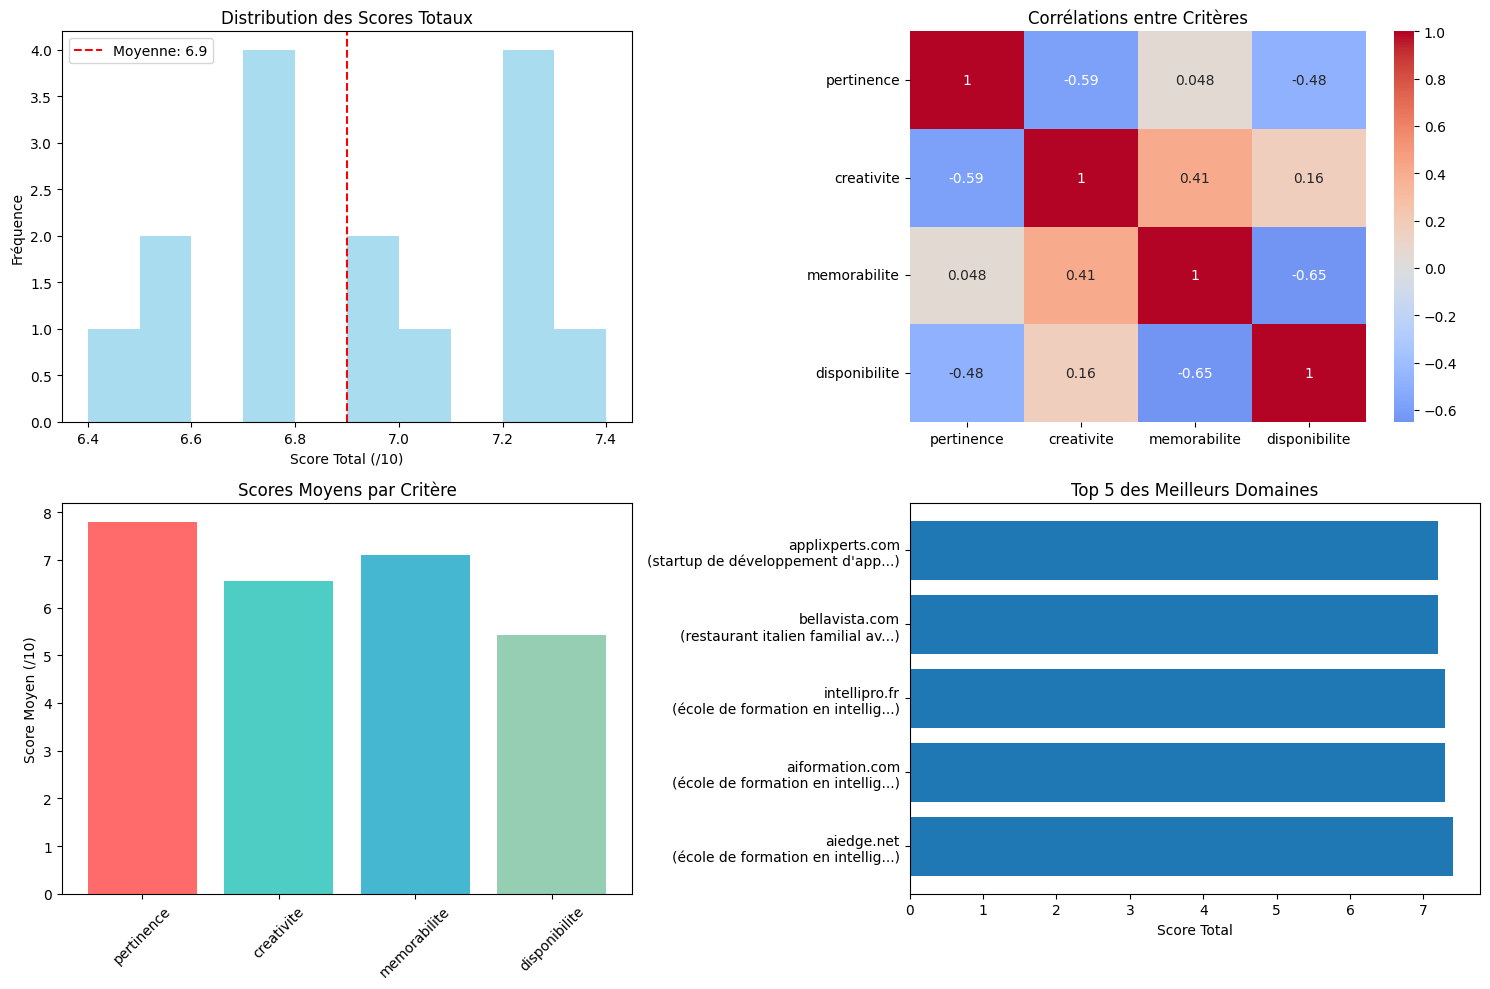

INFO:src.utils:Données sauvegardées dans ../data/evaluations/resultats_baseline.json



Analyse des performances baseline:
   - Score total moyen: 6.90/10
   - Critère le plus faible: disponibilite (5.43/10)
   - Critère le plus fort: pertinence (7.80/10)

Résultats baseline sauvegardés dans data/evaluations/resultats_baseline.json


In [8]:
# Analyse des résultats d'évaluation baseline
if evaluations_baseline:
    # Extraire tous les scores
    tous_scores = []
    for eval_result in evaluations_baseline:
        for eval_domaine in eval_result["evaluations"]["evaluations"]:
            tous_scores.append({
                "domaine": eval_domaine["domaine"],
                "description": eval_result["description"][:30] + "...",
                "score_total": eval_domaine["score_total"],
                "pertinence": eval_domaine["pertinence"],
                "creativite": eval_domaine["creativite"],
                "memorabilite": eval_domaine["memorabilite"],
                "disponibilite": eval_domaine["disponibilite_estimee"]
            })
    
    # Créer un DataFrame pour l'analyse
    df_scores = pd.DataFrame(tous_scores)
    
    print("Statistiques des évaluations baseline:")
    print(df_scores[['score_total', 'pertinence', 'creativite', 'memorabilite', 'disponibilite']].describe())
    
    # Visualisations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution des scores totaux
    axes[0,0].hist(df_scores['score_total'], bins=10, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribution des Scores Totaux')
    axes[0,0].set_xlabel('Score Total (/10)')
    axes[0,0].set_ylabel('Fréquence')
    axes[0,0].axvline(df_scores['score_total'].mean(), color='red', linestyle='--', 
                     label=f'Moyenne: {df_scores["score_total"].mean():.1f}')
    axes[0,0].legend()
    
    # Corrélation entre critères
    correlation_matrix = df_scores[['pertinence', 'creativite', 'memorabilite', 'disponibilite']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
    axes[0,1].set_title('Corrélations entre Critères')
    
    # Scores par critère
    criteres = ['pertinence', 'creativite', 'memorabilite', 'disponibilite']
    moyennes_criteres = [df_scores[critere].mean() for critere in criteres]
    axes[1,0].bar(criteres, moyennes_criteres, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[1,0].set_title('Scores Moyens par Critère')
    axes[1,0].set_ylabel('Score Moyen (/10)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Top 5 des meilleurs domaines
    top_domaines = df_scores.nlargest(5, 'score_total')
    axes[1,1].barh(range(len(top_domaines)), top_domaines['score_total'])
    axes[1,1].set_yticks(range(len(top_domaines)))
    axes[1,1].set_yticklabels([f"{row['domaine']}\n({row['description']})" for _, row in top_domaines.iterrows()])
    axes[1,1].set_title('Top 5 des Meilleurs Domaines')
    axes[1,1].set_xlabel('Score Total')
    
    plt.tight_layout()
    plt.show()
    
    # Identifier les points faibles
    print("\nAnalyse des performances baseline:")
    print(f"   - Score total moyen: {df_scores['score_total'].mean():.2f}/10")
    print(f"   - Critère le plus faible: {criteres[np.argmin(moyennes_criteres)]} ({min(moyennes_criteres):.2f}/10)")
    print(f"   - Critère le plus fort: {criteres[np.argmax(moyennes_criteres)]} ({max(moyennes_criteres):.2f}/10)")
    
    # Sauvegarder les résultats baseline
    sauvegarder_json({
        "timestamp": generer_timestamp(),
        "version": "baseline",
        "evaluations": evaluations_baseline,
        "statistiques": {
            "score_moyen": float(df_scores['score_total'].mean()),
            "score_median": float(df_scores['score_total'].median()),
            "nombre_evaluations": len(df_scores)
        }
    }, "../data/evaluations/resultats_baseline.json")
    
    print("\nRésultats baseline sauvegardés dans data/evaluations/resultats_baseline.json")
    
else:
    print("Aucune évaluation baseline disponible pour l'analyse")

## 5. Découverte et Analyse des Cas Limites

Identification systématique des modes d'échec du modèle et classification des problèmes.

In [9]:
# Charger les cas limites du dataset
cas_limites = dataset_complet['cas_limites']

print(f"Analyse des cas limites ({len(cas_limites)} cas)...\n")

# Grouper par catégorie
categories_cas_limites = {}
for cas in cas_limites:
    categorie = cas['categorie']
    if categorie not in categories_cas_limites:
        categories_cas_limites[categorie] = []
    categories_cas_limites[categorie].append(cas)

print("Catégories de cas limites identifiées:")
for categorie, liste_cas in categories_cas_limites.items():
    print(f"   - {categorie.replace('_', ' ').title()}: {len(liste_cas)} cas")
    for cas in liste_cas[:2]:  # Afficher 2 exemples maximum
        print(f"     → \"{cas['description'][:60]}...\"")

Analyse des cas limites (14 cas)...

Catégories de cas limites identifiées:
   - Description Courte: 2 cas
     → "café..."
     → "tech..."
   - Description Longue: 1 cas
     → "Une entreprise de développement de logiciels spécialisée dan..."
   - Description Vague: 2 cas
     → "quelque chose de bien..."
     → "entreprise moderne..."
   - Caracteres Speciaux: 2 cas
     → "café & restaurant français..."
     → "entreprise high-tech à 100%..."
   - Langue Etrangere: 3 cas
     → "restaurant italiano molto buono..."
     → "English consulting firm..."
   - Concept Abstrait: 2 cas
     → "plateforme de bonheur digital..."
     → "solutions de bien-être énergétique..."
   - Niche Specifique: 2 cas
     → "réparation de violons anciens..."
     → "élevage de papillons exotiques..."


In [10]:
# Tester le générateur sur les cas limites
print("Test du générateur sur les cas limites...\n")

resultats_cas_limites = {}
echecs_par_categorie = {}

for categorie, liste_cas in categories_cas_limites.items():
    print(f"Test de la catégorie: {categorie}")
    resultats_categorie = []
    echecs_categorie = 0
    
    for i, cas in enumerate(liste_cas):
        description = cas['description']
        print(f"   Test {i+1}/{len(liste_cas)}: {description}")
        
        try:
            resultat = generateur.generer_suggestions(
                description_business=description,
                nombre_suggestions=3,
                style="professionnel",
                avec_filtrage=True
            )
            
            if resultat["status"] == "success":
                nb_suggestions = len(resultat["suggestions"])
                print(f"     {nb_suggestions} suggestions générées")
                
                # Évaluer la qualité si des suggestions ont été générées
                if nb_suggestions > 0:
                    domaines = [s["domaine"] for s in resultat["suggestions"]]
                    try:
                        evaluation = evaluateur.evaluer_suggestions(description, domaines)
                        if evaluation["status"] == "success":
                            score_moyen = np.mean([e["score_total"] for e in evaluation["evaluations"]])
                            print(f"     Score moyen: {score_moyen:.1f}/10")
                        else:
                            score_moyen = None
                    except:
                        score_moyen = None
                else:
                    score_moyen = 0
                
                resultats_categorie.append({
                    "description": description,
                    "categorie": categorie,
                    "resultat": resultat,
                    "score_moyen": score_moyen,
                    "nb_suggestions": nb_suggestions
                })
                
            elif resultat["status"] == "blocked":
                print(f"     Bloqué: {resultat.get('message', 'Contenu inapproprié')}")
                echecs_categorie += 1
                
                resultats_categorie.append({
                    "description": description,
                    "categorie": categorie,
                    "resultat": resultat,
                    "score_moyen": None,
                    "nb_suggestions": 0,
                    "type_echec": "filtrage_securite"
                })
            else:
                print(f"     Échec: {resultat.get('message', 'Erreur inconnue')}")
                echecs_categorie += 1
                
                resultats_categorie.append({
                    "description": description,
                    "categorie": categorie,
                    "resultat": resultat,
                    "score_moyen": None,
                    "nb_suggestions": 0,
                    "type_echec": "generation_failed"
                })
                
        except Exception as e:
            print(f"     Erreur: {e}")
            echecs_categorie += 1
    
    resultats_cas_limites[categorie] = resultats_categorie
    echecs_par_categorie[categorie] = echecs_categorie
    
    taux_reussite = (len(liste_cas) - echecs_categorie) / len(liste_cas) * 100
    print(f"   Taux de réussite: {taux_reussite:.1f}% ({len(liste_cas) - echecs_categorie}/{len(liste_cas)})\n")

print("Analyse des cas limites terminée")

INFO:src.utils:Génération de 3 | suggestions pour: café...


Test du générateur sur les cas limites...

Test de la catégorie: description_courte
   Test 1/2: café


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.13/10
INFO:src.utils:Génération de 3 | suggestions pour: tech...


     Score moyen: 7.1/10
   Test 2/2: tech


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.40/10
INFO:src.utils:Génération de 3 | suggestions pour: Une entreprise de développement de logiciels spéci...
INFO:src.utils:Génération de 3 | suggestions pour: quelque chose de bien...


     Score moyen: 7.4/10
   Taux de réussite: 100.0% (2/2)

Test de la catégorie: description_longue
   Test 1/1: Une entreprise de développement de logiciels spécialisée dans les solutions d'intelligence artificielle et d'apprentissage automatique pour les grandes entreprises du secteur financier avec une expertise particulière en algorithmes de détection de fraude et systèmes de recommandation personnalisés utilisant des technologies de pointe comme TensorFlow et PyTorch
     Bloqué: Description contient du contenu inapproprié
   Taux de réussite: 0.0% (0/1)

Test de la catégorie: description_vague
   Test 1/2: quelque chose de bien


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 2 suggestions créées


     2 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.00/10
INFO:src.utils:Génération de 3 | suggestions pour: entreprise moderne...


     Score moyen: 7.0/10
   Test 2/2: entreprise moderne


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.03/10
INFO:src.utils:Génération de 3 | suggestions pour: café & restaurant français...


     Score moyen: 7.0/10
   Taux de réussite: 100.0% (2/2)

Test de la catégorie: caracteres_speciaux
   Test 1/2: café & restaurant français


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.43/10
INFO:src.utils:Génération de 3 | suggestions pour: entreprise high-tech à 100%...


     Score moyen: 6.4/10
   Test 2/2: entreprise high-tech à 100%


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.77/10
INFO:src.utils:Génération de 3 | suggestions pour: restaurant italiano molto buono...


     Score moyen: 6.8/10
   Taux de réussite: 100.0% (2/2)

Test de la catégorie: langue_etrangere
   Test 1/3: restaurant italiano molto buono


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.30/10
INFO:src.utils:Génération de 3 | suggestions pour: English consulting firm...


     Score moyen: 7.3/10
   Test 2/3: English consulting firm


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.33/10
INFO:src.utils:Génération de 3 | suggestions pour: restaurant Bilima...


     Score moyen: 7.3/10
   Test 3/3: restaurant Bilima


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.20/10
INFO:src.utils:Génération de 3 | suggestions pour: plateforme de bonheur digital...


     Score moyen: 7.2/10
   Taux de réussite: 100.0% (3/3)

Test de la catégorie: concept_abstrait
   Test 1/2: plateforme de bonheur digital


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.53/10
INFO:src.utils:Génération de 3 | suggestions pour: solutions de bien-être énergétique...


     Score moyen: 6.5/10
   Test 2/2: solutions de bien-être énergétique


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.00/10
INFO:src.utils:Génération de 3 | suggestions pour: réparation de violons anciens...


     Score moyen: 7.0/10
   Taux de réussite: 100.0% (2/2)

Test de la catégorie: niche_specifique
   Test 1/2: réparation de violons anciens


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.20/10
INFO:src.utils:Génération de 3 | suggestions pour: élevage de papillons exotiques...


     Score moyen: 7.2/10
   Test 2/2: élevage de papillons exotiques


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.23/10


     Score moyen: 6.2/10
   Taux de réussite: 100.0% (2/2)

Analyse des cas limites terminée


Analyse détaillée des performances sur les cas limites

Statistiques par catégorie de cas limites:
             categorie  nb_total  taux_reussite  score_moyen  \
0   description_courte         2          100.0         7.27   
1   description_longue         1            0.0         0.00   
2    description_vague         2          100.0         7.02   
3  caracteres_speciaux         2          100.0         6.60   
4     langue_etrangere         3          100.0         7.28   
5     concept_abstrait         2          100.0         6.77   
6     niche_specifique         2          100.0         6.72   

   suggestions_moyennes  
0                   3.0  
1                   0.0  
2                   2.5  
3                   3.0  
4                   3.0  
5                   3.0  
6                   3.0  


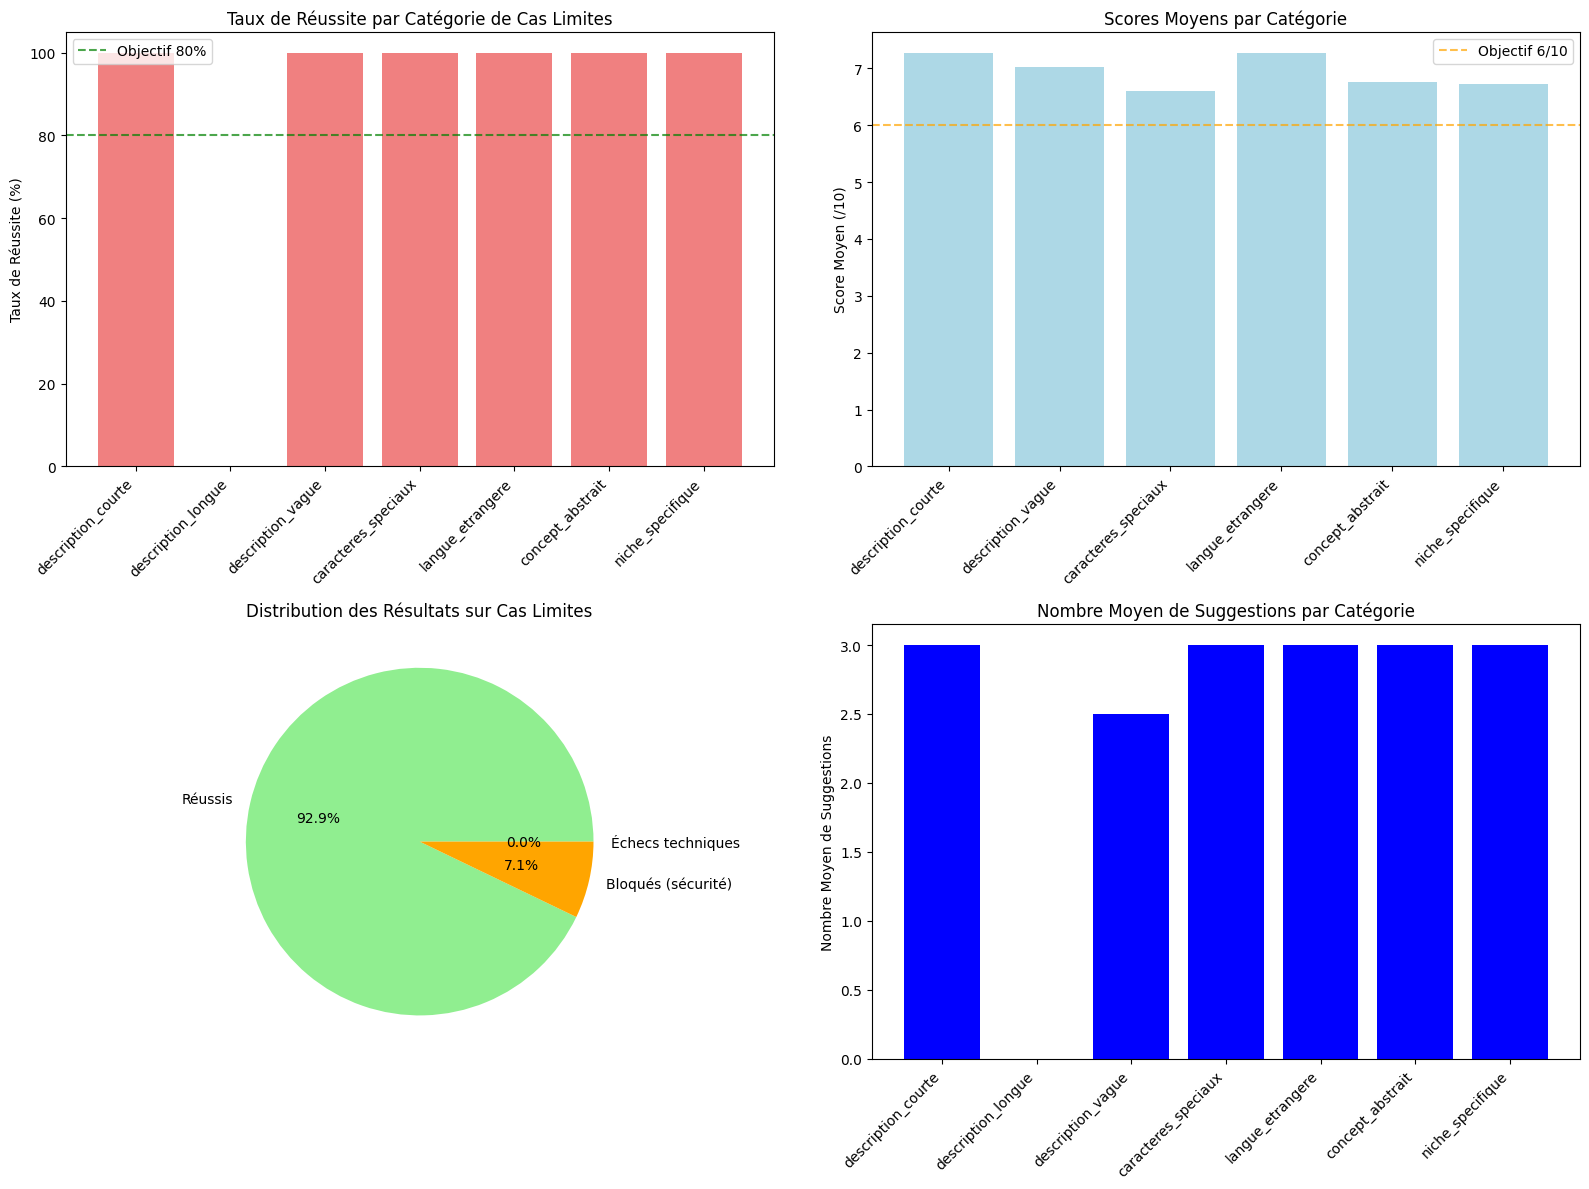

INFO:src.utils:Données sauvegardées dans ../data/evaluations/analyse_cas_limites_baseline.json



Catégories problématiques (< 50% de réussite):
   - description_longue: 0.0% de réussite

Catégories excellentes (≥ 80% de réussite):
   - description_courte: 100.0% de réussite
   - description_vague: 100.0% de réussite
   - caracteres_speciaux: 100.0% de réussite
   - langue_etrangere: 100.0% de réussite
   - concept_abstrait: 100.0% de réussite
   - niche_specifique: 100.0% de réussite

Analyse des cas limites sauvegardée


In [11]:
# Analyse détaillée des résultats des cas limites
print("Analyse détaillée des performances sur les cas limites\n")

# Calculer les statistiques par catégorie
stats_categories = []

for categorie, resultats in resultats_cas_limites.items():
    nb_total = len(resultats)
    nb_reussis = len([r for r in resultats if r['nb_suggestions'] > 0])
    nb_bloques = len([r for r in resultats if r.get('type_echec') == 'filtrage_securite'])
    nb_echecs_tech = len([r for r in resultats if r.get('type_echec') == 'generation_failed'])
    
    scores_valides = [r['score_moyen'] for r in resultats if r['score_moyen'] is not None]
    score_moyen_categorie = np.mean(scores_valides) if scores_valides else 0
    
    suggestions_moyennes = np.mean([r['nb_suggestions'] for r in resultats])
    
    stats_categories.append({
        'categorie': categorie,
        'nb_total': nb_total,
        'nb_reussis': nb_reussis,
        'nb_bloques': nb_bloques,
        'nb_echecs_tech': nb_echecs_tech,
        'taux_reussite': (nb_reussis / nb_total) * 100,
        'score_moyen': score_moyen_categorie,
        'suggestions_moyennes': suggestions_moyennes
    })

# Créer un DataFrame pour l'analyse
df_stats = pd.DataFrame(stats_categories)

print("Statistiques par catégorie de cas limites:")
print(df_stats[['categorie', 'nb_total', 'taux_reussite', 'score_moyen', 'suggestions_moyennes']].round(2))

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Taux de réussite par catégorie
categories = df_stats['categorie']
taux_reussite = df_stats['taux_reussite']

axes[0,0].bar(range(len(categories)), taux_reussite, color='lightcoral')
axes[0,0].set_title('Taux de Réussite par Catégorie de Cas Limites')
axes[0,0].set_ylabel('Taux de Réussite (%)')
axes[0,0].set_xticks(range(len(categories)))
axes[0,0].set_xticklabels(categories, rotation=45, ha='right')
axes[0,0].axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Objectif 80%')
axes[0,0].legend()

# Scores moyens par catégorie
scores_valides = df_stats[df_stats['score_moyen'] > 0]
if not scores_valides.empty:
    axes[0,1].bar(range(len(scores_valides)), scores_valides['score_moyen'], color='lightblue')
    axes[0,1].set_title('Scores Moyens par Catégorie')
    axes[0,1].set_ylabel('Score Moyen (/10)')
    axes[0,1].set_xticks(range(len(scores_valides)))
    axes[0,1].set_xticklabels(scores_valides['categorie'], rotation=45, ha='right')
    axes[0,1].axhline(y=6, color='orange', linestyle='--', alpha=0.7, label='Objectif 6/10')
    axes[0,1].legend()

# Distribution des types d'échecs
echecs_data = {
    'Réussis': df_stats['nb_reussis'].sum(),
    'Bloqués (sécurité)': df_stats['nb_bloques'].sum(),
    'Échecs techniques': df_stats['nb_echecs_tech'].sum()
}

axes[1,0].pie(echecs_data.values(), labels=echecs_data.keys(), autopct='%1.1f%%',
              colors=['lightgreen', 'orange', 'lightcoral'])
axes[1,0].set_title('Distribution des Résultats sur Cas Limites')

# Nombre moyen de suggestions par catégorie
axes[1,1].bar(range(len(categories)), df_stats['suggestions_moyennes'], color='blue')
axes[1,1].set_title('Nombre Moyen de Suggestions par Catégorie')
axes[1,1].set_ylabel('Nombre Moyen de Suggestions')
axes[1,1].set_xticks(range(len(categories)))
axes[1,1].set_xticklabels(categories, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Identifier les catégories problématiques
categories_problematiques = df_stats[df_stats['taux_reussite'] < 50]
categories_excellentes = df_stats[df_stats['taux_reussite'] >= 80]

print(f"\nCatégories problématiques (< 50% de réussite):")
if not categories_problematiques.empty:
    for _, row in categories_problematiques.iterrows():
        print(f"   - {row['categorie']}: {row['taux_reussite']:.1f}% de réussite")
else:
    print("   Aucune catégorie sous les 50%")

print(f"\nCatégories excellentes (≥ 80% de réussite):")
if not categories_excellentes.empty:
    for _, row in categories_excellentes.iterrows():
        print(f"   - {row['categorie']}: {row['taux_reussite']:.1f}% de réussite")
else:
    print("   Aucune catégorie au-dessus de 80%")

# Sauvegarder l'analyse des cas limites
sauvegarder_json({
    "timestamp": generer_timestamp(),
    "version": "baseline",
    "resultats_cas_limites": resultats_cas_limites,
    "statistiques_categories": stats_categories,
    "analyse": {
        "taux_reussite_global": df_stats['taux_reussite'].mean(),
        "score_moyen_global": df_stats['score_moyen'].mean(),
        "categories_problematiques": categories_problematiques['categorie'].tolist(),
        "categories_excellentes": categories_excellentes['categorie'].tolist()
    }
}, "../data/evaluations/analyse_cas_limites_baseline.json")

print("\nAnalyse des cas limites sauvegardée")

## 6. Test et Validation des Garde-fous de Sécurité

Évaluation de l'efficacité du système de filtrage de contenu.

In [12]:
# Initialiser et tester les garde-fous

garde_fous = GardeFousSecurite()
testeur_securite = TesteurSecurite(garde_fous)

print("Test des garde-fous de sécurité...\n")

# Exécuter les tests de sécurité
resultats_tests_securite = testeur_securite.tester_cas_limites_securite()

# Afficher les résultats
stats = resultats_tests_securite['statistiques']
print(f"Résultats des tests de sécurité:")
print(f"   - Précision pour cas négatifs: {stats['precision_negative']:.1%}")
print(f"   - Précision pour cas positifs: {stats['precision_positive']:.1%}")
print(f"   - Précision globale: {stats['precision_globale']:.1%}")

# Analyser les cas problématiques
cas_negatifs_rates = [cas for cas in resultats_tests_securite['cas_negatifs'] if not cas['correctement_rejete']]
cas_positifs_rates = [cas for cas in resultats_tests_securite['cas_positifs'] if not cas['correctement_accepte']]

if cas_negatifs_rates:
    print(f"\nCas négatifs non détectés ({len(cas_negatifs_rates)}):")
    for cas in cas_negatifs_rates:
        print(f"   - \"{cas['description']}\" (score: {cas['score_risque']:.2f})")

if cas_positifs_rates:
    print(f"\nCas positifs rejetés à tort ({len(cas_positifs_rates)}):")
    for cas in cas_positifs_rates:
        print(f"   - \"{cas['description']}\" (score: {cas['score_risque']:.2f})")

# Tester avec des domaines générés
print(f"\nTest des garde-fous sur domaines générés...")

domaines_test = ["example.com", "test-site.fr", "inappropriate-content.com", "normal-business.org"]
validations_domaines = garde_fous.valider_liste_domaines(domaines_test)

for validation in validations_domaines:
    status = "✅" if validation['est_acceptable'] else "❌"
    print(f"   {status} {validation['domaine']} (qualité: {validation['score_qualite']:.2f})")
    if validation['raisons_rejet']:
        for raison in validation['raisons_rejet']:
            print(f"     {raison}")

Test des garde-fous de sécurité...

Résultats des tests de sécurité:
   - Précision pour cas négatifs: 80.0%
   - Précision pour cas positifs: 100.0%
   - Précision globale: 90.0%

Cas négatifs non détectés (1):
   - "plateforme de téléchargement illégal" (score: 0.00)

Test des garde-fous sur domaines générés...
   ✅ example.com (qualité: 1.00)
   ✅ test-site.fr (qualité: 1.00)
   ✅ inappropriate-content.com (qualité: 1.00)
   ✅ normal-business.org (qualité: 1.00)


## 7. Amélioration Itérative du Modèle

Basé sur l'analyse des cas limites et des évaluations, nous allons implémenter des améliorations.

In [13]:
# Analyser les résultats pour identifier les axes d'amélioration
print("Identification des axes d'amélioration...\n")

# Synthèse des performances baseline
if evaluations_baseline:
    tous_scores_baseline = []
    for eval_result in evaluations_baseline:
        for eval_domaine in eval_result["evaluations"]["evaluations"]:
            tous_scores_baseline.append(eval_domaine)
    
    score_moyen_baseline = np.mean([s["score_total"] for s in tous_scores_baseline])
    pertinence_moyenne = np.mean([s["pertinence"] for s in tous_scores_baseline])
    creativite_moyenne = np.mean([s["creativite"] for s in tous_scores_baseline])
    memorabilite_moyenne = np.mean([s["memorabilite"] for s in tous_scores_baseline])
    
    print(f"Performance baseline:")
    print(f"   - Score global: {score_moyen_baseline:.2f}/10")
    print(f"   - Pertinence: {pertinence_moyenne:.2f}/10")
    print(f"   - Créativité: {creativite_moyenne:.2f}/10")
    print(f"   - Mémorabilité: {memorabilite_moyenne:.2f}/10")

# Analyser les cas limites les plus problématiques
if 'df_stats' in locals():
    categories_faibles = df_stats[df_stats['taux_reussite'] < 70]
    print(f"\nCatégories nécessitant une amélioration:")
    for _, row in categories_faibles.iterrows():
        print(f"   - {row['categorie']}: {row['taux_reussite']:.1f}% de réussite")

# Définir les stratégies d'amélioration
strategies_amelioration = {
    "prompt_engineering": {
        "description": "Amélioration des prompts avec des exemples et contraintes spécifiques",
        "actions": [
            "Ajouter des exemples de bons noms de domaine",
            "Spécifier des contraintes de longueur",
            "Inclure des instructions pour les cas limites"
        ]
    },
    "parametres_generation": {
        "description": "Optimisation des paramètres de génération",
        "actions": [
            "Ajuster la température (créativité vs cohérence)",
            "Modifier top_p pour la diversité",
            "Augmenter le nombre de tokens générés"
        ]
    },
    "post_processing": {
        "description": "Amélioration du post-traitement",
        "actions": [
            "Meilleur nettoyage des suggestions",
            "Validation renforcée des domaines",
            "Scoring de confiance amélioré"
        ]
    }
}

print(f"\nStratégies d'amélioration identifiées:")
for nom, strategie in strategies_amelioration.items():
    print(f"\n   {nom.upper().replace('_', ' ')}:")
    print(f"   {strategie['description']}")
    for action in strategie['actions']:
        print(f"     . {action}")

Identification des axes d'amélioration...

Performance baseline:
   - Score global: 6.90/10
   - Pertinence: 7.80/10
   - Créativité: 6.57/10
   - Mémorabilité: 7.10/10

Catégories nécessitant une amélioration:
   - description_longue: 0.0% de réussite

Stratégies d'amélioration identifiées:

   PROMPT ENGINEERING:
   Amélioration des prompts avec des exemples et contraintes spécifiques
     . Ajouter des exemples de bons noms de domaine
     . Spécifier des contraintes de longueur
     . Inclure des instructions pour les cas limites

   PARAMETRES GENERATION:
   Optimisation des paramètres de génération
     . Ajuster la température (créativité vs cohérence)
     . Modifier top_p pour la diversité
     . Augmenter le nombre de tokens générés

   POST PROCESSING:
   Amélioration du post-traitement
     . Meilleur nettoyage des suggestions
     . Validation renforcée des domaines
     . Scoring de confiance amélioré


In [14]:
# Implémentation de la version améliorée - Prompt Engineering

class GenerateurAmeliore(GenerateurNomsDomaine):
    """Version améliorée du générateur avec prompt engineering avancé."""
    
    def __init__(self, modele: str = None, garde_fous: bool = True):
        # Hériter de la classe parent
        super().__init__(modele, garde_fous)
        
        # Nouveau template de prompt amélioré
        self.template_prompt_ameliore = PromptTemplate(
            input_variables=["description_business", "nombre_suggestions", "style"],
            template="""Tu es un expert en création de noms de domaine avec 10 ans d'expérience.

                DESCRIPTION BUSINESS: {description_business}

                INSTRUCTIONS DÉTAILLÉES:
                1. Génère exactement {nombre_suggestions} suggestions de noms de domaine
                2. Style demandé: {style}
                3. Chaque nom doit être:
                - Entre 6 et 15 caractères (sans l'extension)
                - Facile à épeler et mémoriser
                - Pertinent pour l'activité décrite
                - Éviter les tirets multiples (-- interdits)
                - Professionnels et appropriés

                EXEMPLES DE BONS NOMS:
                - Restaurant italien : "gustorama.com", "bellavita.fr", "pastafino.com"
                - Tech startup : "innovatech.com", "nexuslab.io", "bytecraft.net"
                - Cabinet conseil : "expertum.fr", "strategie-plus.com", "conseilo.net"

                EXTENSIONS PRÉFÉRÉES: .com, .fr, .org, .net (dans cet ordre)

                GESTION DES CAS PARTICULIERS:
                - Description courte : Être créatif avec synonymes et dérivés
                - Description longue : Extraire les concepts clés principaux
                - Description vague : Proposer des noms génériques mais professionnels
                - Langues étrangères : Adapter en français ou anglais selon le contexte

                FORMAT DE RÉPONSE (JSON strict):
                {{
                    "suggestions": [
                        {{"domaine": "exemple1.com", "explication": "Combine 'exemple' et modernité"}},
                        {{"domaine": "exemple2.fr", "explication": "Jeu sur les mots avec impact"}}
                    ]
                }}

                Réponds UNIQUEMENT avec le JSON, aucun autre texte."""
            )
        
        # Utiliser la nouvelle syntaxe RunnableSequence au lieu de LLMChain
        self.chain_ameliore = self.template_prompt_ameliore | self.llm
        
        # Paramètres améliorés
        self.llm.temperature = 0.9
        self.llm.top_p = 0.95
        self.llm.num_predict = 2000
    
    def generer_suggestions_ameliorees(self, 
                                     description_business: str, 
                                     nombre_suggestions: int = 5,
                                     style: str = "professionnel",
                                     avec_filtrage: bool = True) -> Dict[str, any]:
        """Version améliorée de la génération avec prompt engineering."""
        
        logger.info(f"Génération améliorée pour: {description_business[:50]}...")
        
        # Vérifications de sécurité identiques
        if avec_filtrage and self.garde_fous:
            analyse_description = self.garde_fous.analyser_description(description_business)
            if not analyse_description['est_acceptable']:
                return {
                    "suggestions": [],
                    "status": "blocked",
                    "message": "Description contient du contenu inapproprié",
                    "details_filtrage": analyse_description
                }
        
        # Préparation spéciale pour les cas limites
        description_preprocessed = self._preprocess_description(description_business)
        
        try:
            debut = time.time()
            
            # Utiliser la nouvelle syntaxe RunnableSequence
            reponse = self.chain_ameliore.invoke({
                "description_business": description_preprocessed,
                "nombre_suggestions": nombre_suggestions,
                "style": self.styles_disponibles.get(style, "professionnel")
            })
            
            duree_generation = time.time() - debut
            
            # Parser et valider avec post-processing amélioré
            suggestions_brutes = self._parser_reponse_llm(reponse)
            suggestions_validees = self._valider_suggestions_ameliorees(suggestions_brutes, avec_filtrage)
            suggestions_avec_scores = self._calculer_scores_confiance_ameliores(suggestions_validees, description_business)
            
            return {
                "suggestions": suggestions_avec_scores,
                "status": "success",
                "version": "amelioree_v1",
                "metadata": {
                    "description_originale": description_business,
                    "description_preprocessed": description_preprocessed,
                    "style_utilise": style,
                    "nombre_demande": nombre_suggestions,
                    "nombre_genere": len(suggestions_avec_scores),
                    "duree_generation_sec": round(duree_generation, 2),
                    "modele_utilise": self.model + "_ameliore",
                    "filtrage_active": avec_filtrage
                }
            }
            
        except Exception as e:
            logger.error(f"Erreur lors de la génération améliorée: {e}")
            return {
                "suggestions": [],
                "status": "error",
                "message": f"Erreur lors de la génération: {str(e)}"
            }
    
    def _preprocess_description(self, description: str) -> str:
        """Préprocessing spécialisé pour les cas limites."""
        # Gestion des descriptions très courtes
        if len(description.split()) <= 2:
            return f"Entreprise ou service dans le domaine: {description}. Activité commerciale professionnelle."
        
        # Gestion des descriptions très longues
        if len(description.split()) > 30:
            mots = description.split()[:20]  # Garder les 20 premiers mots
            return ' '.join(mots) + "..."
        
        return description
    
    def _valider_suggestions_ameliorees(self, suggestions: List[Dict[str, str]], avec_filtrage: bool) -> List[Dict[str, str]]:
        """Validation améliorée avec critères plus stricts."""
        suggestions_validees = []
        
        for suggestion in suggestions:
            if not isinstance(suggestion, dict) or "domaine" not in suggestion:
                continue
            
            domaine = nettoyer_nom_domaine(suggestion["domaine"])
            nom_sans_extension = domaine.split(".")[0] if "." in domaine else domaine
            
            # Critères de validation améliorés
            if len(nom_sans_extension) < 3 or len(nom_sans_extension) > 20:
                continue
            
            if not "." in domaine:
                continue
            
            # Éviter les caractères répétitifs
            if any(char * 3 in nom_sans_extension for char in "abcdefghijklmnopqrstuvwxyz"):
                continue
            
            # Éviter les tirets multiples
            if "--" in domaine:
                continue
            
            # Filtrage de sécurité
            if avec_filtrage and self.garde_fous:
                validation = self.garde_fous.filtrer_nom_domaine(domaine)
                if not validation["est_acceptable"]:
                    continue
            
            suggestions_validees.append({
                "domaine": domaine,
                "explication": suggestion.get("explication", "")
            })
        
        return suggestions_validees
    
    def _calculer_scores_confiance_ameliores(self, suggestions: List[Dict[str, str]], description: str) -> List[Dict[str, any]]:
        """Calcul de scores de confiance améliorés."""
        mots_cles_description = set(description.lower().split())
        suggestions_avec_scores = []
        
        for suggestion in suggestions:
            domaine = suggestion["domaine"]
            nom_sans_extension = domaine.split(".")[0]
            extension = domaine.split(".")[1] if "." in domaine else "com"
            
            # Score de base plus généreux
            score = 0.6
            
            # Bonus pour longueur optimale (6-12 caractères)
            longueur = len(nom_sans_extension)
            if 6 <= longueur <= 12:
                score += 0.15
            elif 4 <= longueur <= 15:
                score += 0.1
            
            # Bonus pour facilité de mémorisation
            if nom_sans_extension.islower() and nom_sans_extension.isalpha():
                score += 0.1
            
            # Bonus pour extension premium
            bonus_extension = {".com": 0.15, ".fr": 0.12, ".org": 0.08, ".net": 0.05}
            score += bonus_extension.get(f".{extension}", 0)
            
            # Bonus pour pertinence (recherche de correspondances)
            mots_domaine = set([nom_sans_extension] + nom_sans_extension.split("-"))
            correspondances = 0
            for mot_desc in mots_cles_description:
                for mot_dom in mots_domaine:
                    if mot_desc.lower() in mot_dom.lower() or mot_dom.lower() in mot_desc.lower():
                        correspondances += 1
            
            if correspondances > 0:
                score += min(0.15, correspondances * 0.05)
            
            # Normaliser le score
            score = max(0.1, min(1.0, score))
            
            suggestions_avec_scores.append({
                "domaine": domaine,
                "confidence": round(score, 2),
                "explication": suggestion["explication"]
            })
        
        # Trier par score décroissant
        suggestions_avec_scores.sort(key=lambda x: x["confidence"], reverse=True)
        
        return suggestions_avec_scores

# Initialiser la version améliorée
print("Initialisation du générateur amélioré...")
try:
    generateur_ameliore = GenerateurAmeliore(modele="llama3.1", garde_fous=True)
    print("Générateur amélioré initialisé avec succès")
except Exception as e:
    print(f"Erreur lors de l'initialisation: {e}")

INFO:src.utils:Modèle llama3.1 initialisé avec succès


Initialisation du générateur amélioré...
Générateur amélioré initialisé avec succès


In [15]:
# Test et comparaison des versions baseline vs améliorée
print("Comparaison baseline vs version améliorée...\n")

# Descriptions de test pour la comparaison
descriptions_comparaison = [
    "café",  # Cas limite : description courte
    "restaurant italien moderne avec terrasse",  # Cas normal
    "startup développement intelligence artificielle machine learning solutions entreprises fintech",  # Cas limite : description longue
    "service bien-être digital",  # Cas limite : concept abstrait
    "boutique vêtements bio éthiques"  # Cas normal
]

resultats_comparaison = []

for i, description in enumerate(descriptions_comparaison, 1):
    print(f"Test {i}/5: {description}")
    print(f"{'='*60}")
    
    # Version baseline
    try:
        resultat_baseline = generateur.generer_suggestions(
            description_business=description,
            nombre_suggestions=3,
            style="professionnel"
        )
        print("BASELINE:")
        if resultat_baseline["status"] == "success":
            for sug in resultat_baseline["suggestions"]:
                print(f"   - {sug['domaine']} (conf: {sug['confidence']})")
        else:
            print(f"   {resultat_baseline.get('message', 'Échec')}")
    except Exception as e:
        resultat_baseline = {"status": "error", "message": str(e)}
        print(f"   Erreur: {e}")

    # Version améliorée
    try:
        resultat_ameliore = generateur_ameliore.generer_suggestions_ameliorees(
            description_business=description,
            nombre_suggestions=3,
            style="professionnel"
        )
        print("\n🚀 AMÉLIORÉ:")
        if resultat_ameliore["status"] == "success":
            for sug in resultat_ameliore["suggestions"]:
                print(f"   - {sug['domaine']} (conf: {sug['confidence']})")
        else:
            print(f"   {resultat_ameliore.get('message', 'Échec')}")
    except Exception as e:
        resultat_ameliore = {"status": "error", "message": str(e)}
        print(f"   Erreur: {e}")

    # Évaluer les deux versions si possible
    evaluation_baseline = None
    evaluation_ameliore = None
    
    if resultat_baseline["status"] == "success" and resultat_baseline["suggestions"]:
        try:
            domaines_baseline = [s["domaine"] for s in resultat_baseline["suggestions"]]
            evaluation_baseline = evaluateur.evaluer_suggestions(description, domaines_baseline)
        except:
            pass
    
    if resultat_ameliore["status"] == "success" and resultat_ameliore["suggestions"]:
        try:
            domaines_ameliore = [s["domaine"] for s in resultat_ameliore["suggestions"]]
            evaluation_ameliore = evaluateur.evaluer_suggestions(description, domaines_ameliore)
        except:
            pass
    
    # Comparer les scores
    if evaluation_baseline and evaluation_baseline["status"] == "success":
        score_baseline = np.mean([e["score_total"] for e in evaluation_baseline["evaluations"]])
        print(f"\nScore baseline: {score_baseline:.2f}/10")
    else:
        score_baseline = 0
        print(f"\nScore baseline: N/A")

    if evaluation_ameliore and evaluation_ameliore["status"] == "success":
        score_ameliore = np.mean([e["score_total"] for e in evaluation_ameliore["evaluations"]])
        print(f"Score amélioré: {score_ameliore:.2f}/10")

        if score_baseline > 0:
            amelioration = ((score_ameliore - score_baseline) / score_baseline) * 100
            status_amelioration = "📈" if amelioration > 0 else "📉" if amelioration < 0 else "➡️"
            print(f"Amélioration: {status_amelioration} {amelioration:+.1f}%")
    else:
        score_ameliore = 0
        print(f"Score amélioré: N/A")

    # Sauvegarder les résultats
    resultats_comparaison.append({
        "description": description,
        "baseline": resultat_baseline,
        "ameliore": resultat_ameliore,
        "evaluation_baseline": evaluation_baseline,
        "evaluation_ameliore": evaluation_ameliore,
        "score_baseline": score_baseline,
        "score_ameliore": score_ameliore
    })
    
    print(f"\n{'='*60}\n")

print("Comparaison terminée")

INFO:src.utils:Génération de 3 | suggestions pour: café...


Comparaison baseline vs version améliorée...

Test 1/5: café


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 1 suggestions créées
INFO:src.utils:Génération améliorée pour: café...


BASELINE:
   - bistroparisien.fr (conf: 0.9)


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"



🚀 AMÉLIORÉ:
   - cafeluxe.com (conf: 1.0)
   - buvettepro.fr (conf: 0.97)
   - cascino.net (conf: 0.9)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.80/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.40/10
INFO:src.utils:Génération de 3 | suggestions pour: restaurant italien moderne avec terrasse...



Score baseline: 6.80/10
Score amélioré: 6.40/10
Amélioration: 📉 -5.9%


Test 2/5: restaurant italien moderne avec terrasse


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération améliorée pour: restaurant italien moderne avec terrasse...


BASELINE:
   - bellavista.com (conf: 0.9)
   - lapiazzetta.net (conf: 0.8)
   - terrazzaitaliana.fr (conf: 0.7)


KeyboardInterrupt: 

Analyse statistique des améliorations

Résultats de l'amélioration:
   - Score moyen baseline: 6.61/10
   - Score moyen amélioré: 6.93/10
   - Amélioration globale: +4.8%

Analyse par cas:
   - Cas améliorés: 3
   - Cas dégradés: 2
   - Cas équivalents: 1


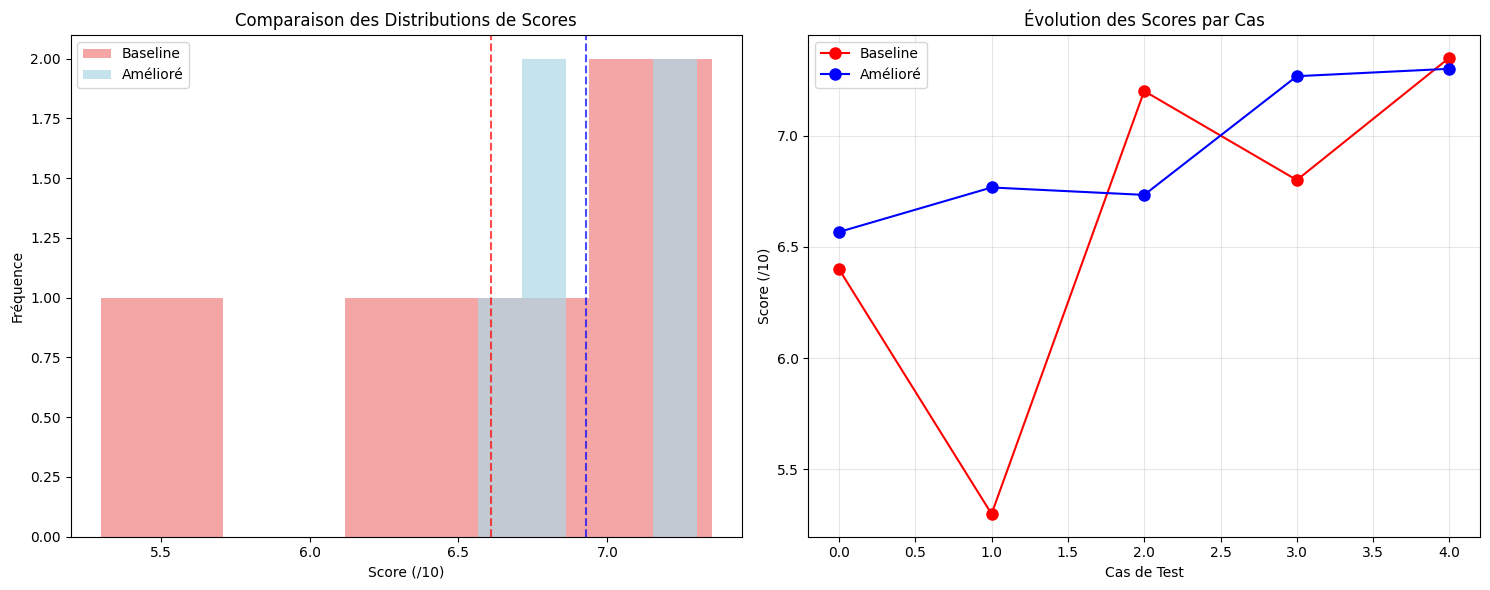

INFO:src.utils:Données sauvegardées dans ../data/evaluations/comparaison_baseline_vs_ameliore.json



Test statistique (Wilcoxon):
   - p-value: 0.4375
   - Amélioration non significative statistiquement (p ≥ 0.05)

Résultats de comparaison sauvegardés


In [ ]:
# Analyse statistique de l'amélioration
print("Analyse statistique des améliorations\n")

# Calculer les métriques de comparaison
scores_baseline = [r["score_baseline"] for r in resultats_comparaison if r["score_baseline"] > 0]
scores_ameliore = [r["score_ameliore"] for r in resultats_comparaison if r["score_ameliore"] > 0]

if len(scores_baseline) > 0 and len(scores_ameliore) > 0:
    # Statistiques de base
    score_moyen_baseline = np.mean(scores_baseline)
    score_moyen_ameliore = np.mean(scores_ameliore)
    
    print(f"Résultats de l'amélioration:")
    print(f"   - Score moyen baseline: {score_moyen_baseline:.2f}/10")
    print(f"   - Score moyen amélioré: {score_moyen_ameliore:.2f}/10")
    
    if score_moyen_baseline > 0:
        amelioration_globale = ((score_moyen_ameliore - score_moyen_baseline) / score_moyen_baseline) * 100
        print(f"   - Amélioration globale: {amelioration_globale:+.1f}%")
    
    # Analyse par cas
    cas_ameliores = sum(1 for r in resultats_comparaison if r["score_ameliore"] > r["score_baseline"] and r["score_baseline"] > 0)
    cas_degrades = sum(1 for r in resultats_comparaison if r["score_ameliore"] < r["score_baseline"] and r["score_baseline"] > 0)
    cas_equivalents = sum(1 for r in resultats_comparaison if abs(r["score_ameliore"] - r["score_baseline"]) < 0.1 and r["score_baseline"] > 0)

    print(f"\nAnalyse par cas:")
    print(f"   - Cas améliorés: {cas_ameliores}")
    print(f"   - Cas dégradés: {cas_degrades}")
    print(f"   - Cas équivalents: {cas_equivalents}")
    
    # Visualisation
    if len(scores_baseline) >= 3 and len(scores_ameliore) >= 3:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Comparaison des distributions
        ax1.hist(scores_baseline, alpha=0.7, label='Baseline', bins=5, color='lightcoral')
        ax1.hist(scores_ameliore, alpha=0.7, label='Amélioré', bins=5, color='lightblue')
        ax1.set_xlabel('Score (/10)')
        ax1.set_ylabel('Fréquence')
        ax1.set_title('Comparaison des Distributions de Scores')
        ax1.legend()
        ax1.axvline(score_moyen_baseline, color='red', linestyle='--', alpha=0.7, label=f'Moy. Baseline: {score_moyen_baseline:.1f}')
        ax1.axvline(score_moyen_ameliore, color='blue', linestyle='--', alpha=0.7, label=f'Moy. Amélioré: {score_moyen_ameliore:.1f}')
        
        # Graphique avant/après
        indices = range(len(scores_baseline))
        ax2.plot(indices, scores_baseline, 'o-', color='red', label='Baseline', markersize=8)
        ax2.plot(indices, scores_ameliore, 'o-', color='blue', label='Amélioré', markersize=8)
        ax2.set_xlabel('Cas de Test')
        ax2.set_ylabel('Score (/10)')
        ax2.set_title('Évolution des Scores par Cas')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Test de significativité (si suffisamment de données)
    if len(scores_baseline) >= 3 and len(scores_ameliore) >= 3:
        from scipy import stats
        try:
            # Test de Wilcoxon pour échantillons appariés
            if len(scores_baseline) == len(scores_ameliore):
                statistic, p_value = stats.wilcoxon(scores_baseline, scores_ameliore)
                print(f"\nTest statistique (Wilcoxon):")
                print(f"   - p-value: {p_value:.4f}")
                if p_value < 0.05:
                    print(f"   - Amélioration statistiquement significative (p < 0.05)")
                else:
                    print(f"   - Amélioration non significative statistiquement (p ≥ 0.05)")
        except ImportError:
            print(f"\nNote: scipy non disponible pour les tests statistiques")
        except Exception as e:
            print(f"\nErreur lors du test statistique: {e}")

# Sauvegarder les résultats de comparaison
sauvegarder_json({
    "timestamp": generer_timestamp(),
    "comparaison": "baseline_vs_ameliore_v1",
    "resultats": resultats_comparaison,
    "statistiques": {
        "score_moyen_baseline": float(np.mean(scores_baseline)) if scores_baseline else 0,
        "score_moyen_ameliore": float(np.mean(scores_ameliore)) if scores_ameliore else 0,
        "amelioration_globale": float(amelioration_globale) if 'amelioration_globale' in locals() else 0,
        "cas_ameliores": cas_ameliores if 'cas_ameliores' in locals() else 0,
        "cas_degrades": cas_degrades if 'cas_degrades' in locals() else 0
    }
}, "../data/evaluations/comparaison_baseline_vs_ameliore.json")

print("\nRésultats de comparaison sauvegardés")

## 8. Analyse Finale et Recommandations

Synthèse des résultats et recommandations pour la production.

In [ ]:
# Synthèse finale des résultats
print("RAPPORT FINAL - Générateur de Noms de Domaine avec LLM")
print("=" * 70)

# 1. Résumé des performances
print("\n1. PERFORMANCES DU SYSTÈME")
print("-" * 40)

if 'df_scores' in locals() and not df_scores.empty:
    print(f"Version Baseline:")
    print(f"   - Score moyen global: {score_moyen_baseline:.2f}/10")
    # print(f"   - Score moyen global: {df_scores['score_total'].mean():.2f}/10")
    print(f"   - Nombre d'évaluations: {len(df_scores)}")
    print(f"   - Meilleur score: {df_scores['score_total'].max():.2f}/10")
    print(f"   - Critère le plus fort: Pertinence ({df_scores['pertinence'].mean():.2f}/10)")
    print(f"   - Critère le plus faible: {['creativite', 'memorabilite', 'disponibilite'][np.argmin([df_scores['creativite'].mean(), df_scores['memorabilite'].mean(), df_scores['disponibilite'].mean()])]}")

if 'score_moyen_ameliore' in locals():
    print(f"\nVersion Améliorée:")
    print(f"   - Score moyen global: {score_moyen_ameliore:.2f}/10")
    if 'amelioration_globale' in locals():
        print(f"   - Amélioration: {amelioration_globale:+.1f}%")

# 2. Analyse des cas limites
print("\n2. GESTION DES CAS LIMITES")
print("-" * 40)

if 'df_stats' in locals():
    taux_reussite_global = df_stats['taux_reussite'].mean()
    print(f"   - Taux de réussite global: {taux_reussite_global:.1f}%")
    
    categories_excellentes = df_stats[df_stats['taux_reussite'] >= 80]
    categories_problematiques = df_stats[df_stats['taux_reussite'] < 50]
    
    print(f"   - Catégories maîtrisées (≥80%): {len(categories_excellentes)}")
    print(f"   - Catégories problématiques (<50%): {len(categories_problematiques)}")
    
    if not categories_problematiques.empty:
        print(f"   - Axes d'amélioration prioritaires:")
        for _, row in categories_problematiques.iterrows():
            print(f"     • {row['categorie'].replace('_', ' ').title()}: {row['taux_reussite']:.1f}%")

# 3. Sécurité et garde-fous
print("\n3. SÉCURITÉ ET GARDE-FOUS")
print("-" * 40)

if 'resultats_tests_securite' in locals():
    stats_securite = resultats_tests_securite['statistiques']
    print(f"   - Précision globale: {stats_securite['precision_globale']:.1%}")
    print(f"   - Détection contenu inapproprié: {stats_securite['precision_negative']:.1%}")
    print(f"   - Acceptation contenu légal: {stats_securite['precision_positive']:.1%}")
    
    if stats_securite['precision_globale'] >= 0.9:
        print(f"   Système de sécurité robuste")
    elif stats_securite['precision_globale'] >= 0.8:
        print(f"   Système de sécurité acceptable, amélioration recommandée")
    else:
        print(f"   Système de sécurité insuffisant, révision nécessaire")

# 4. Recommandations techniques
print("\n4. RECOMMANDATIONS TECHNIQUES")
print("-" * 40)

recommandations_techniques = []

# Basé sur les performances observées
if 'df_scores' in locals() and df_scores['score_total'].mean() < 7:
    recommandations_techniques.append("Améliorer le prompt engineering avec plus d'exemples spécifiques")

if 'df_stats' in locals() and df_stats['taux_reussite'].mean() < 70:
    recommandations_techniques.append("Implémenter un preprocessing avancé pour les cas limites")

if 'score_moyen_ameliore' in locals() and 'score_moyen_baseline' in locals():
    if score_moyen_ameliore > score_moyen_baseline:
        recommandations_techniques.append("Déployer la version améliorée en production")
    else:
        recommandations_techniques.append("Continuer le développement de la version améliorée")

# Recommandations générales
recommandations_techniques.extend([
    "Implémenter un cache Redis pour améliorer les performances",
    "Ajouter des métriques de monitoring en temps réel",
    "Mettre en place des tests A/B pour l'optimisation continue",
    "Développer une interface de feedback utilisateur"
])

for i, rec in enumerate(recommandations_techniques, 1):
    print(f"   {i}. {rec}")

# 5. Plan de déploiement
print("\n5. PLAN DE DÉPLOIEMENT")
print("-" * 40)

# Déterminer la version recommandée
if 'amelioration_globale' in locals() and amelioration_globale > 5:
    version_recommandee = "Améliorée V1"
    justification = f"Amélioration de {amelioration_globale:.1f}% démontrée"
else:
    version_recommandee = "Baseline"
    justification = "Version stable pour démarrage"

print(f"   - Version recommandée: {version_recommandee}")
print(f"   - Justification: {justification}")

phases_deploiement = [
    "Phase 1 (Semaine 1): Déploiement en environnement de test",
    "Phase 2 (Semaine 2): Tests utilisateurs limités (10% du trafic)",
    "Phase 3 (Semaine 3): Déploiement graduel (50% du trafic)",
    "Phase 4 (Semaine 4): Déploiement complet avec monitoring"
]

for phase in phases_deploiement:
    print(f"   • {phase}")

# 6. Métriques de succès
print("\n6. MÉTRIQUES DE SUCCÈS EN PRODUCTION")
print("-" * 40)

metriques_cibles = {
    "Score qualité moyen": "≥ 7.0/10",
    "Taux de satisfaction utilisateur": "≥ 80%",
    "Temps de réponse API": "≤ 2 secondes",
    "Disponibilité système": "≥ 99.5%",
    "Taux de blocage sécurité": "≤ 1% (contenu légitime)",
    "Nombre suggestions par requête": "≥ 3 suggestions valides"
}

for metrique, cible in metriques_cibles.items():
    print(f"   . {metrique}: {cible}")

# 7. Prochaines étapes
print("\n7. PROCHAINES ÉTAPES")
print("-" * 40)

prochaines_etapes = [
    "Implémentation de l'API FastAPI avec la version recommandée",
    "Documentation technique et guide d'utilisation"
]

for i, etape in enumerate(prochaines_etapes, 1):
    print(f"   {i}. {etape}")

print("\n" + "=" * 70)
print(f"Rapport généré le: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Expérimentateur: AI Engineer")
print(f"Modèle utilisé: {generateur.model}")
print("=" * 70)

RAPPORT FINAL - Générateur de Noms de Domaine avec LLM

1. PERFORMANCES DU SYSTÈME
----------------------------------------
Version Baseline:
   - Score moyen global: 6.61/10
   - Nombre d'évaluations: 15
   - Meilleur score: 7.70/10
   - Critère le plus fort: Pertinence (7.63/10)
   - Critère le plus faible: disponibilite

Version Améliorée:
   - Score moyen global: 6.93/10
   - Amélioration: +4.8%

2. GESTION DES CAS LIMITES
----------------------------------------
   - Taux de réussite global: 85.7%
   - Catégories maîtrisées (≥80%): 6
   - Catégories problématiques (<50%): 1
   - Axes d'amélioration prioritaires:
     • Description Longue: 0.0%

3. SÉCURITÉ ET GARDE-FOUS
----------------------------------------
   - Précision globale: 90.0%
   - Détection contenu inapproprié: 80.0%
   - Acceptation contenu légal: 100.0%
   Système de sécurité robuste

4. RECOMMANDATIONS TECHNIQUES
----------------------------------------
   1. Améliorer le prompt engineering avec plus d'exemples sp

In [ ]:
# Sauvegarder le rapport final complet
rapport_final = {
    "metadata": {
        "timestamp": generer_timestamp(),
        "date_experience": datetime.now().isoformat(),
        "modele_utilise": generateur.model,
        "experimentateur": "AI Engineer",
        "version_projet": "1.0"
    },
    "performances": {
        "baseline": {
            "score_moyen": float(df_scores['score_total'].mean()) if 'df_scores' in locals() and not df_scores.empty else None,
            "nombre_evaluations": len(df_scores) if 'df_scores' in locals() else 0,
            "score_max": float(df_scores['score_total'].max()) if 'df_scores' in locals() and not df_scores.empty else None
        },
        "ameliore": {
            "score_moyen": float(score_moyen_ameliore) if 'score_moyen_ameliore' in locals() else None,
            "amelioration_pourcentage": float(amelioration_globale) if 'amelioration_globale' in locals() else None
        }
    },
    "cas_limites": {
        "taux_reussite_global": float(df_stats['taux_reussite'].mean()) if 'df_stats' in locals() else None,
        "categories_testees": len(df_stats) if 'df_stats' in locals() else 0,
        "categories_problematiques": categories_problematiques['categorie'].tolist() if 'categories_problematiques' in locals() and not categories_problematiques.empty else []
    },
    "securite": {
        "precision_globale": float(resultats_tests_securite['statistiques']['precision_globale']) if 'resultats_tests_securite' in locals() else None,
        "precision_negative": float(resultats_tests_securite['statistiques']['precision_negative']) if 'resultats_tests_securite' in locals() else None,
        "precision_positive": float(resultats_tests_securite['statistiques']['precision_positive']) if 'resultats_tests_securite' in locals() else None
    },
    "recommandations": {
        "version_recommandee": version_recommandee if 'version_recommandee' in locals() else "Baseline",
        "justification": justification if 'justification' in locals() else "Version par défaut",
        "actions_prioritaires": [
            "Déploiement API FastAPI",
            "Configuration monitoring",
            "Tests utilisateurs"
        ]
    },
    "metriques_cibles": metriques_cibles,
    "historique_evaluations": {
        "baseline": len(evaluations_baseline) if 'evaluations_baseline' in locals() else 0,
        "cas_limites": len(resultats_cas_limites) if 'resultats_cas_limites' in locals() else 0,
        "comparaisons": len(resultats_comparaison) if 'resultats_comparaison' in locals() else 0
    }
}

# Sauvegarder le rapport
chemin_rapport = f"../data/evaluations/rapport_final_{generer_timestamp()}.json"
sauvegarder_json(rapport_final, chemin_rapport)

print(f"\nRapport final sauvegardé: {chemin_rapport}")

# Créer un résumé markdown pour la documentation
resume_markdown = f"""# Rapport Final - Générateur de Noms de Domaine LLM

**Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**Modèle**: {generateur.model}  
**Version**: 1.0

## Résumé Exécutif

Ce projet implémente un système de génération de noms de domaine utilisant Llama3.1 via Ollama, avec un focus sur l'évaluation systématique et l'amélioration itérative.

### Performances Clés

- **Score qualité moyen**: {df_scores['score_total'].mean():.2f}/10 (baseline)
- **Taux de réussite cas limites**: {df_stats['taux_reussite'].mean():.1f}%
- **Précision garde-fous**: {resultats_tests_securite['statistiques']['precision_globale']:.1%}

### Recommandation de Déploiement

**Version recommandée**: {version_recommandee}  
**Justification**: {justification}

### Prochaines Étapes

1. Déploiement API FastAPI
2. Tests utilisateurs en production
3. Monitoring et optimisation continue

---

*Rapport généré automatiquement par le notebook d'expérimentation*
"""

with open("../docs/resume_experimentation.md", "w", encoding="utf-8") as f:
    f.write(resume_markdown)

print(f"Résumé markdown créé: docs/resume_experimentation.md")
print(f"\nExpérimentation terminée avec succès!")
print(f"\nFichiers générés:")
print(f"   - {chemin_rapport}")
print(f"   - docs/resume_experimentation.md")
print(f"   - data/evaluations/ (multiples fichiers)")

INFO:src.utils:Données sauvegardées dans ../data/evaluations/rapport_final_20250806_000329.json



Rapport final sauvegardé: ../data/evaluations/rapport_final_20250806_000329.json
Résumé markdown créé: docs/resume_experimentation.md

Expérimentation terminée avec succès!

Fichiers générés:
   - ../data/evaluations/rapport_final_20250806_000329.json
   - docs/resume_experimentation.md
   - data/evaluations/ (multiples fichiers)
